In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))   
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 12 Feb 2018

Distributed under the terms of the MIT License.

# Notebook for screening FASTA sequence files for their pI

TODO:
- move to scripts
    - generalise to running in current working dir
    - add license
- screening function
    - get another method for calculating exposure without structure?
- modifications
    - introduce exposure consideration
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list
- timing information on small dataset
    - per sequence as a function of length
    - per sequence as a function of number of ionisable residues
- turn notebook into presentation of process for an example.

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
import time
import numpy as np
%aimport pi_fn
%aimport parameters

# Notes:
## Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


## modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/test_dataset/'
# database_directory = '/home/atarzia/psp/sequence_db/linb_dataset/'
output_dir = '/home/atarzia/psp/sequence_db/test_dataset/'
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)

# output CSV file
redo_pi = True
if redo_pi is True:
    string = ''
    for i in param_dict['out_columns_pi']:
        if i == param_dict['out_columns_pi'][-1]:
            string += i
        else:
            string += i+','
    string += '\n'
    with open(output_dir+param_dict['out_CSV_pi'], 'w') as f:
        f.write(string)

In [4]:
# need to fix the FASTA output format so BIOPYTHON can read it
# for each FASTA file
for file in database_names:
    file_mod = file.replace(".fasta", "_mod.fasta")
    with open(file, 'r') as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        if '|' in line and ">" not in line:
            # we replace spaces in header line with "__" 
            # so I can manipulate that later as biopython does not like "__"
            new_line = ">"+line.replace(" ","__")
            new_lines.append(new_line)
        else:
            new_lines.append(line)
    with open(file_mod, 'w') as f:
        for line in new_lines:
            f.write(line)

In [6]:
def convert_to_one_letter_code_sing(seq):
    conversion = {"GLY":"G","PRO":"P","VAL":"V","ALA":"A","LEU":"L",
                  "ILE":"I","MET":"M","CYS":"C","PHE":"F","TYR":"Y",
                  "TRP":"W","HIS":"H","ARG":"R","LYS":"K","GLN":"Q",
                  "THR":"T","ASP":"D","ASN":"N","SER":"S","GLU":"E"}
    n_seq = conversion[seq]
    return n_seq

In [7]:
print('=====================================================================')
print('                      Screening sequences with pI!                   ')
print('=====================================================================')
modifications = param_dict['modifications']
# for each FASTA file
for file in database_names:
    count_sequences_done = 0
    total_start_time = time.time()
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    file_mod = file.replace(".fasta", "_mod.fasta")
    with open(file_mod, "r") as handle:
        print("--- Doing:", file_mod, "---")
        for record in SeqIO.parse(handle, "fasta", alphabet=IUPAC.protein):
            start_time = time.time()
            record_list = record.description.split("|")
            # get meta data
            acc_code = record_list[0]
            organism = record_list[1]
            EC_code = record_list[2].replace("__"," ")
            species = record_list[3].replace("__"," ")
            note = record_list[4]
            # get unmodified pI
            seq = record.seq
            seq_obj = ProteinAnalysis(''.join(seq))
            pi = seq_obj.isoelectric_point()
            count_sequences_done += 1
            modifier = '0'
            if pi < param_dict['cutoff_pi']:
                category = '0'
            else:
                category = '1'
            # output to CSV
            with open(output_dir+param_dict['out_CSV_pi'], 'a') as f:
                string = file+','
                string += acc_code+','
                string += organism+','
                string += EC_code+','
                string += species+','
                string += note+','
                string += '{0:.2f}'.format(pi)+','
                string += modifier+','
                string += category+',\n'
                f.write(string)
            
            # if the category is 1 - i.e. pi > cutoff
            # then we test modification - else we do not
            if category == '1':
                modifier = '1'
                # get modified pI
                seq = record.seq
                # replace target amino acid residue
                # with replacement amino acid residue
                # one letter codes
                targ = convert_to_one_letter_code_sing(modifications[modifier]['target_res'])
                replacement = convert_to_one_letter_code_sing(modifications[modifier]['replace_res'])
                mod_seq = ''.join(seq).replace(targ, replacement)
                seq_obj = ProteinAnalysis(mod_seq)
                pi = seq_obj.isoelectric_point()
                count_sequences_done += 1
                if pi < param_dict['cutoff_pi']:
                    category = '0'
                else:
                    category = '1'
                # output to CSV
                with open(output_dir+param_dict['out_CSV_pi'], 'a') as f:
                    string = file+','
                    string += acc_code+','
                    string += organism+','
                    string += EC_code+','
                    string += species+','
                    string += note+','
                    string += '{0:.2f}'.format(pi)+','
                    string += modifier+','
                    string += category+'\n'
                    f.write(string)
            #break
    print('--- finished %s sequences in %s seconds ---' % (count_sequences_done, '{0:.2f}'.format(time.time() - total_start_time)))
print('=====================================================================')
print('                              Complete!                              ')
print('=====================================================================')

                      Screening sequences with pI!                   
--- Doing: /home/atarzia/psp/sequence_db/test_dataset/6_6_1_2__BRENDA_sequences_mod.fasta ---
--- finished 2750 sequences in 1.28 seconds ---
                              Complete!                              


## plot all pIs in output CSV
### colour by modification


In [8]:
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

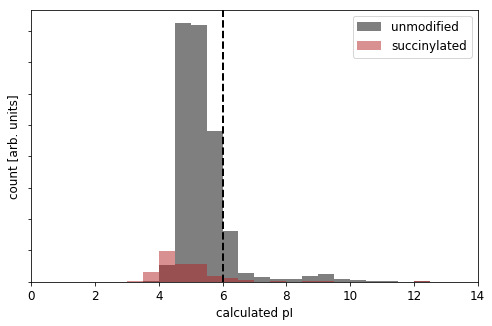

In [9]:
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(8, 5))
# unmodifed
mod_dict = modifications['0']
data = pi_data[pi_data['modification'] == 0]
n, bins, patches = ax.hist(data['pi'], facecolor=mod_dict['colour'], alpha = 0.5, 
                           bins=np.arange(0, 14 + 0.2, 0.5),
                           label = mod_dict['name'])

# modification 1 - succinylation
mod_dict = modifications['1']
data = pi_data[pi_data['modification'] == 1]
n, bins, patches = ax.hist(data['pi'], facecolor=mod_dict['colour'], alpha = 0.5, 
                           bins=np.arange(0, 14 + 0.2, 0.5),
                           label = mod_dict['name'])

ax.set_xlabel('calculated pI')
ax.set_ylabel('count [arb. units]')
ax.set_yticklabels([])

#plot cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')

ax.set_xlim(0, 14)
ax.legend()


fig.savefig(output_dir+'pI_histogram.pdf', dpi=720, bbox_inches='tight')